In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install "dask[dataframe]"
!pip install "dask[bag]"
!pip install "dask[array]"

     |████████████████████████████████| 132 kB 4.3 MB/s 


In [ ]:
import pandas as pd
import json
import numpy as np
import dask.bag as db
import dask.dataframe as dd # substitute of pandas to load the data in streams
import dask.array as da
import matplotlib.pyplot as plt

In [ ]:
# Import the review dataset as streams to avoid running out of memory
dict_bag = db.read_text('yelp_academic_dataset_review.json', blocksize=int(5e6)).map(json.loads)
df_r = dict_bag.to_dataframe(columns=['business_id', 'stars', 'text'])
df_r = df_r.repartition(npartitions=10)
#df_r.head()

In [ ]:
# Business dataset
dict_bag = db.read_text('yelp_academic_dataset_business.json', blocksize=int(5e6)).map(json.loads)
df_b = dict_bag.to_dataframe(columns=['business_id', 'city', 'stars', 'categories'])
df_b = df_b.repartition(npartitions=10)
#df_b.head()

In [ ]:
# Users dataset (Import it in streams again)
dict_bag = db.read_text('yelp_academic_dataset_user.json', blocksize=int(5e6)).map(json.loads)
df_u = dict_bag.to_dataframe(columns=['user_id', 'friends', 'review_count'])
df_u = df_u.repartition(npartitions=10)
#df_u.head()

In [ ]:
df_b = df_b.compute()
df_b = df_b.dropna()

In [ ]:
df_b_mex = df_b[df_b['categories'].str.contains("Mexican")]
df_b_amer = df_b[df_b['categories'].str.contains("American")]

In [ ]:
df_r = df_r.compute()

In [ ]:
df = pd.merge(df_b_mex, df_r, how='inner', on='business_id')

In [ ]:
df.head()

,business_id,city,stars_x,categories,stars_y,text
0,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,I don't like the closeness to the road or the ...
1,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",4.0,Pretty solid food truck. I tried the Chicken T...
2,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",4.0,This is another trailer within about a mile of...
3,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,I love this stand and eat here frequently. The...
4,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,While doing the touristy thing we happened upo...


In [ ]:
import feather
path = 'business_mex.feather'
feather.write_dataframe(df_b, path)
path2 = 'review_mex.feather'
feather.write_dataframe(df, path2)

In [ ]:
df_b.to_csv('american.csv')

In [ ]:
df_b.to_csv('business.csv')

In [ ]:
# Text analysis of reviews to mexican restaurants

In [ ]:
!pip install sklearn
!pip install nltk

In [ ]:
#Cleaning
import nltk
import string
from nltk.corpus import stopwords
nltk.download("stopwords")
sw_nltk = stopwords.words('english')
nt = []
n = 480501
for i in range(n):
  s = str(df['text'].values[i])
  words = [word for word in s.split() if word.lower() not in sw_nltk]
  new_text = " ".join(words)
  new_text = new_text.translate(str.maketrans('', '', string.punctuation))
  nt.append(new_text.lower()) 
df['new_text'] = nt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = df.drop(columns='text')

In [ ]:
tokens = df['new_text'].str.split().tolist()
# # Create a counter for each work and it's frequency
# from collections import Counter
# counter = Counter(tokens) 
# # Keep top X words with higher frequency
# most_occur = Counter.most_common(1000) 

In [ ]:
from collections import Counter
count = dict(Counter(word for sentence in tokens for word in sentence))
important = {key: value for key, value in count.items() if value > 1000}

In [ ]:
words = np.array([key for key, value in important.items()])
vec_words = full_text = ' '.join(words)

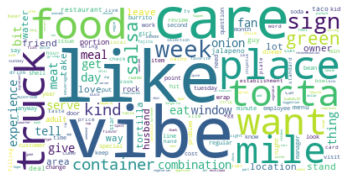

<Figure size 432x288 with 0 Axes>

In [ ]:
from wordcloud import WordCloud
my_stop_words = set(stopwords.words('english')+ ['one', 'order', 'side', 'make'])
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(vec_words)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('words1.png')


In [ ]:
# Analyz only bad reviews
df2 = df
df = df[df.stars_x < 2.5]
df

,business_id,city,stars_x,categories,stars_y,text
11,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1.5,"Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...",4.0,"Literally not a thing, anything at all, in my..."
12,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1.5,"Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...",1.0,This is probably the worst Taco Bell I've ever...
13,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1.5,"Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...",2.0,A few years back a guy offered to take me here...
14,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1.5,"Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...",1.0,the employee is bathing in the parking lot whi...
15,Of6xu3pY3eHe2yhiyz2dvg,Boulder,1.5,"Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...",1.0,"Like others have said, this place is always cl..."
...,...,...,...,...,...,...
479626,sexYEzEBgE2sxgI5InSaDQ,Austin,2.0,"Restaurants, Mexican, Breakfast & Brunch, Tex-...",1.0,"Long time Taco Bell supporter (yes, I know whe..."
479627,sexYEzEBgE2sxgI5InSaDQ,Austin,2.0,"Restaurants, Mexican, Breakfast & Brunch, Tex-...",1.0,"Let me start by saying, I rarely eat fast food..."
479628,sexYEzEBgE2sxgI5InSaDQ,Austin,2.0,"Restaurants, Mexican, Breakfast & Brunch, Tex-...",1.0,"The worst service of all of the chains, was th..."
479629,sexYEzEBgE2sxgI5InSaDQ,Austin,2.0,"Restaurants, Mexican, Breakfast & Brunch, Tex-...",1.0,I love Taco Bell but this one here is by far t...


In [ ]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download("stopwords")
sw_nltk = stopwords.words('english')
nt = []
n = 12300
for i in range(n):
  s = str(df['text'].values[i])
  words = [word for word in s.split() if word.lower() not in sw_nltk]
  new_text = " ".join(words)
  new_text = new_text.translate(str.maketrans('', '', string.punctuation))
  nt.append(new_text.lower()) 
df['new_text'] = nt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df = df.drop(columns='text')
tokens = df['new_text'].str.split().tolist()
from collections import Counter
count = dict(Counter(word for sentence in tokens for word in sentence))
important = {key: value for key, value in count.items() if value > 1000}
words = np.array([key for key, value in important.items()])
vec_words = full_text = ' '.join(words)

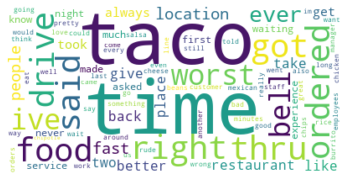

<Figure size 432x288 with 0 Axes>

In [ ]:
from wordcloud import WordCloud
my_stop_words = set(stopwords.words('english')+ ['one', 'order', 'side', 'make'])
cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(vec_words)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('words2.png')


In [ ]:
from nltk import FreqDist
token_dist = FreqDist(vec_words)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])

In [ ]:
important = {key: value for key, value in important.items() if key not in sw_nltk}
normal_words = ['get', 'one', 'like' ,'good', 'even', 'bad', 'go', 'even', 'drive', 'back', 'got', 'would']
important = {key: value for key, value in important.items() if key not in normal_words}

In [ ]:
important

{'2': 1326,
 '3': 1102,
 'also': 1642,
 'always': 2441,
 'another': 1158,
 'around': 1244,
 'asked': 1802,
 'beans': 1050,
 'bell': 3267,
 'better': 1346,
 'burrito': 2101,
 'came': 1437,
 'cheese': 1560,
 'chicken': 1974,
 'chipotle': 2621,
 'chips': 1304,
 'come': 1610,
 'could': 1703,
 'customer': 1509,
 'eat': 1432,
 'employees': 1367,
 'ever': 1961,
 'every': 1250,
 'experience': 1158,
 'fast': 1769,
 'first': 1341,
 'food': 10125,
 'give': 1748,
 'going': 1731,
 'great': 1590,
 'im': 2425,
 'ive': 2443,
 'know': 1650,
 'last': 1166,
 'line': 2189,
 'location': 4132,
 'long': 1301,
 'love': 1091,
 'made': 1216,
 'make': 1503,
 'manager': 1575,
 'mexican': 1158,
 'minutes': 2765,
 'much': 1283,
 'never': 2553,
 'night': 1162,
 'order': 6348,
 'ordered': 2512,
 'orders': 1061,
 'people': 2190,
 'place': 4164,
 'pretty': 1172,
 'really': 1985,
 'restaurant': 1581,
 'rice': 1226,
 'right': 1284,
 'rude': 1002,
 'said': 1967,
 'salsa': 1322,
 'say': 1239,
 'service': 4226,
 'something'

In [ ]:
important
df_bad = important. items()
df_bad = list(df_bad)
df_bad = pd.DataFrame(df_bad, columns=['word', 'freq'])
df_bad = df_bad.sort_values(by='freq', ascending=False)
df_bad

,word,freq
2,food,10125
0,order,6348
8,taco,5800
22,time,4981
25,service,4226
...,...,...
74,orders,1061
79,beans,1050
55,think,1040
24,waiting,1038


In [ ]:
df_bad.head(10)

,word,freq
2,food,10125
0,order,6348
8,taco,5800
22,time,4981
25,service,4226
20,place,4164
12,location,4132
9,bell,3267
37,minutes,2765
83,chipotle,2621


In [ ]:
df_bad = df_bad.head(10)
bad_words = df_bad['word'].values

In [ ]:
nt = []
n = 480501
for i in range(n):
  s = str(df2['text'].values[i])
  words = [word for word in s.split() if word.lower() not in sw_nltk]
  new_text = " ".join(words)
  new_text = new_text.translate(str.maketrans('', '', string.punctuation))
  nt.append(new_text.lower()) 
df2['new_text'] = nt

In [ ]:
df2 = df2.drop(columns='text')

In [ ]:
df2

,business_id,city,stars_x,categories,stars_y,new_text
0,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,like closeness road east side vibe general neg...
1,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",4.0,pretty solid food truck tried chicken torta de...
2,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",4.0,another trailer within mile apartment ive twic...
3,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,love stand eat frequently char cooked chicken ...
4,Xw8tuI30T-xihpzwBV-zJg,Austin,5.0,"Food Trucks, Restaurants, Specialty Food, Food...",5.0,touristy thing happened upon hidden gem portio...
...,...,...,...,...,...,...
480496,uXdQkuEtvLAzfc3MsO-sTQ,Atlanta,3.0,"Restaurants, Mexican, Latin American",5.0,forget literally anyone crying about business ...
480497,uXdQkuEtvLAzfc3MsO-sTQ,Atlanta,3.0,"Restaurants, Mexican, Latin American",3.0,really appreciate fact restaurant open 24hours...
480498,uXdQkuEtvLAzfc3MsO-sTQ,Atlanta,3.0,"Restaurants, Mexican, Latin American",5.0,24hr mexican spot open drivethru corona take c...
480499,uXdQkuEtvLAzfc3MsO-sTQ,Atlanta,3.0,"Restaurants, Mexican, Latin American",5.0,always line moves quickly food always fresh ho...


In [ ]:
ratings = []
for wd in bad_words:
  df_aux = df2[df2['new_text'].str.contains(wd)]
  ratings.append(np.mean(df_aux['stars_x'].values))

In [ ]:
df_bad['rating'] = ratings
df_bad

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,word,freq,rating
2,food,10125,3.666006
0,order,6348,3.618024
8,taco,5800,3.807968
22,time,4981,3.615171
25,service,4226,3.617980
20,place,4164,3.716509
12,location,4132,3.410268
9,bell,3267,3.357516
37,minutes,2765,3.444142
83,chipotle,2621,3.268289


In [ ]:
# analyze taco bell

In [ ]:
df_bell = df2[df2['new_text'].str.contains("taco bell")]
df_no = df2[~df2['new_text'].str.contains("taco bell")]

In [ ]:
print(np.mean(df_bell['stars_x']))
print(np.mean(df_no['stars_x']))

2.901899936668778
3.703067671591135


In [ ]:
df_b_mex = pd.merge(df_b_mex, df_no, how='inner', on='business_id')

In [ ]:
np.mean(df_b_mex['stars'])

3.703067671591135

In [ ]:
np.mean(df_b['stars'])

3.6580046114538542

In [ ]:
df_b.stars.quantile([0.25,0.5,0.75])

0.25    3.0
0.50    4.0
0.75    4.5
Name: stars, dtype: float64

In [ ]:
df_b_mex.to_csv('notacobell.csv')